# 📘 04 – Individualized Modeling for Each Thruster (SN)
در این نوت‌بوک، برای هر رانشگر به صورت جداگانه مدل XGBoost آموزش داده می‌شود تا عملکرد thrust با دقت بالاتری پیش‌بینی شود.


🎯 هدف این مرحله:
آموزش یک مدل جداگانه برای هر رانشگر (SN01 تا SN12) تا به جای یک مدل عمومی، مدل مخصوص هر پیشران ساخته بشه.

In [22]:
import matplotlib.pyplot as plt

def plot_residuals(sn, df, model, features, target='thrust', n_points=300):
    df_sn = df[df['sn'] == sn].dropna(subset=features + [target])
    if len(df_sn) < n_points:
        print(f"⚠️ SN {sn}: داده کافی برای رسم Residuals وجود ندارد.")
        return
    
    X = df_sn[features].to_numpy()
    y_true = df_sn[target].to_numpy()
    y_pred = model.predict(X)
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 4))
    plt.plot(residuals[:n_points], color='red')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f"SN {sn} – Residual Plot (Actual - Predicted)")
    plt.xlabel("Sample")
    plt.ylabel("Residual (N)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

metadata_path = 'C:/Users/kingGester/Desktop/data/raw/metadata.csv'
meta = pd.read_csv(metadata_path)

def get_full_path(row):
    folder = 'train' if row['sn'] <= 12 else 'test'
    return f"C:/Users/kingGester/Desktop/data/raw/{folder}/{row['filename']}"

meta['full_path'] = meta.apply(get_full_path, axis=1)

train_data = meta[meta['sn'] .isin([1,2,3])]

# prossec CSV
def process_test_file(file_path, target_column='thrust'):
    if not os.path.exists(file_path):
        print(f"🚨 فایل {file_path} پیدا نشد.")
        return None
    try:
        df = pd.read_csv(file_path)
        if target_column not in df.columns:
            print(f"❌ ستون {target_column} در فایل {file_path} وجود ندارد.")
            return None

        df = df[['ton', target_column]].copy()
        df.dropna(inplace=True)

        on_duration = []
        count = 0
        for ton in df['ton']:
            count = count + 1 if ton == 1 else 0
            on_duration.append(count)
        df['on_duration'] = on_duration

        df['lag_thrust_1'] = df[target_column].shift(1)
        df.dropna(inplace=True)

        df['source_file'] = file_path
        return df

    except Exception as e:
        print(f"🚨 erore {file_path}: {e}")
        return None

all_train_frames = []
for idx, row in train_data.iterrows():
    file_path = row['full_path']
    sn_value = row['sn']

    df = process_test_file(file_path)
    if df is not None:
        df['sn'] = sn_value
        all_train_frames.append(df)

df_train = pd.concat(all_train_frames, ignore_index=True)

df_train['rolling_avg_thrust'] = df_train.groupby('sn')['thrust'].rolling(window=5).mean().reset_index(drop=True)
df_train['cumulative_on_time'] = df_train.groupby('sn')['on_duration'].cumsum()

features = ['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time']
target = 'thrust'

os.makedirs("models/individual", exist_ok=True)

serial_numbers = df_train['sn'].unique()
results = []

for sn in serial_numbers:
    print(f"\n🔧 Training model for SN: {sn}")

    df_sn = df_train[df_train['sn'] == sn].dropna(subset=features + [target])
    
    if len(df_sn) < 100:
        print(f"⚠️ داده کافی برای {sn} وجود ندارد.")
        continue

    X = df_sn[features].to_numpy()
    y = df_sn[target].to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        'SN': sn,
        'MAE': mae,
        'R2': r2
    })

    joblib.dump(model, f"models/individual/xgb_model_{sn}.joblib")
    print(f"✅ SN {sn} | MAE: {mae:.4f} | R²: {r2:.4f}")

results_df = pd.DataFrame(results)
display(results_df.sort_values(by='R2', ascending=False).reset_index(drop=True))



🔧 Training model for SN: 1
✅ SN 1 | MAE: 0.0223 | R²: 0.9811

🔧 Training model for SN: 2
✅ SN 2 | MAE: 0.0212 | R²: 0.9818

🔧 Training model for SN: 3
✅ SN 3 | MAE: 0.0239 | R²: 0.9781


,SN,MAE,R2
0,2,0.021169,0.981848
1,1,0.022282,0.981106
2,3,0.023854,0.978130


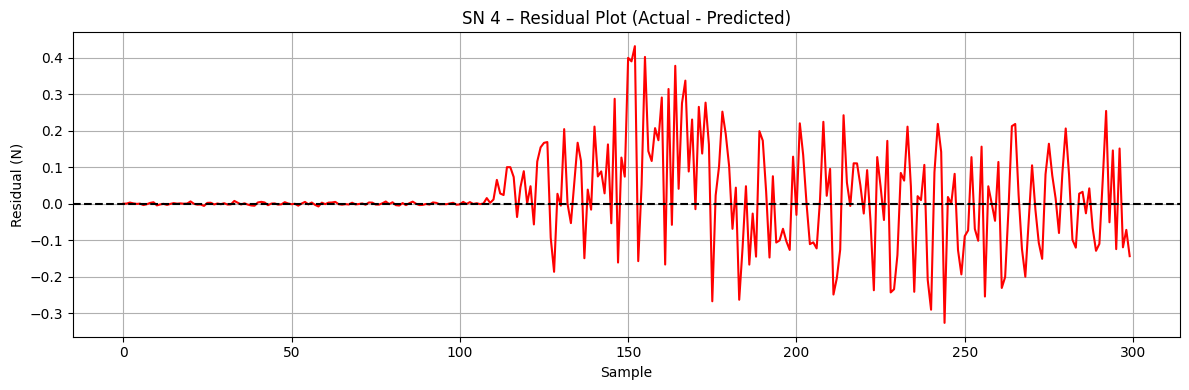

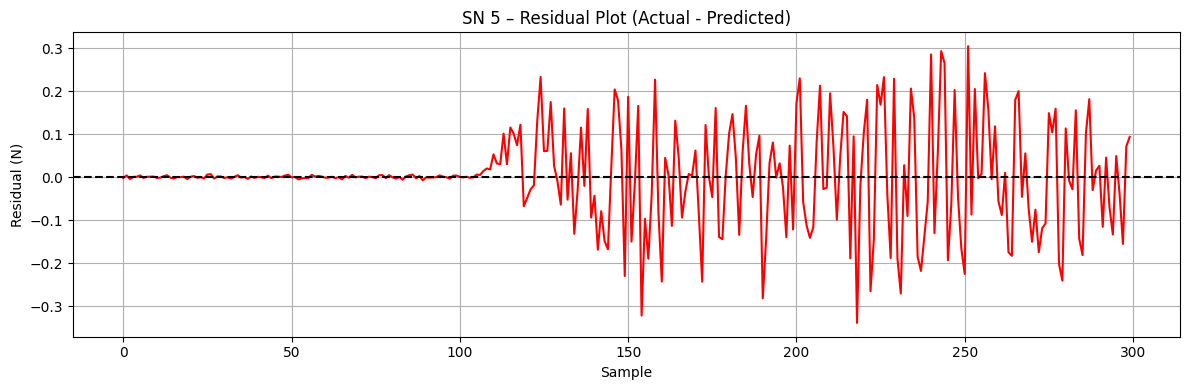

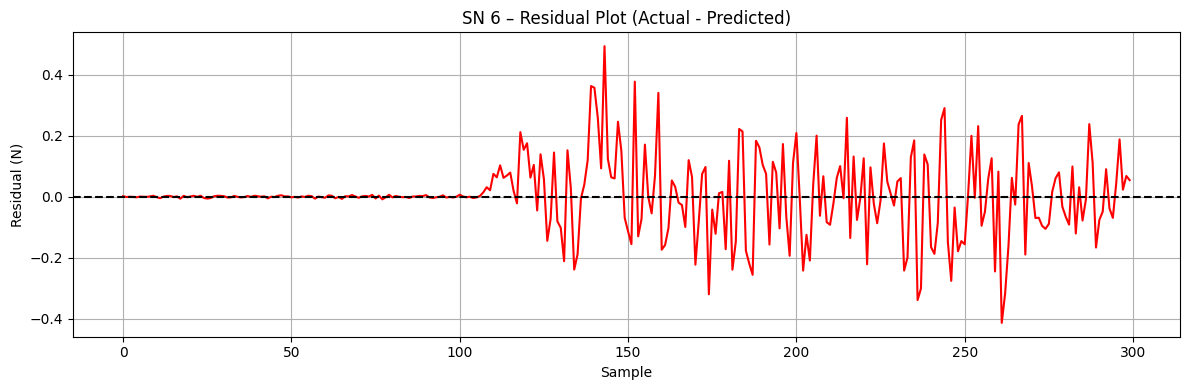

In [25]:
for sn in df_train['sn'].unique():
    df_sn = df_train[df_train['sn'] == sn]
    if df_sn.shape[0] < 100:
        print(f"⛔ SN {sn} داده کافی ندارد.")
        continue
    
    try:
        model = joblib.load(f"models/individual/xgb_model_{sn}.joblib")
        plot_residuals(sn, df_train, model, features)
    except Exception as e:
        print(f"⚠️ SN {sn}: خطا در لود مدل یا رسم نمودار: {e}")


 ## 📦 کد آموزش مدل مجزا برای هر SN:4,5,6

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

metadata_path = 'C:/Users/kingGester/Desktop/data/raw/metadata.csv'
meta = pd.read_csv(metadata_path)

def get_full_path(row):
    folder = 'train' if row['sn'] <= 12 else 'test'
    return f"C:/Users/kingGester/Desktop/data/raw/{folder}/{row['filename']}"

meta['full_path'] = meta.apply(get_full_path, axis=1)

train_data = meta[meta['sn'] .isin([4,5,6])]

def process_test_file(file_path, target_column='thrust'):
    if not os.path.exists(file_path):
        print(f"🚨 فایل {file_path} پیدا نشد.")
        return None
    try:
        df = pd.read_csv(file_path)
        if target_column not in df.columns:
            print(f"❌ ستون {target_column} در فایل {file_path} وجود ندارد.")
            return None

        df = df[['ton', target_column]].copy()
        df.dropna(inplace=True)

        on_duration = []
        count = 0
        for ton in df['ton']:
            count = count + 1 if ton == 1 else 0
            on_duration.append(count)
        df['on_duration'] = on_duration

        df['lag_thrust_1'] = df[target_column].shift(1)
        df.dropna(inplace=True)

        df['source_file'] = file_path
        return df

    except Exception as e:
        print(f"🚨 خطا در فایل {file_path}: {e}")
        return None

all_train_frames = []
for idx, row in train_data.iterrows():
    file_path = row['full_path']
    sn_value = row['sn']

    df = process_test_file(file_path)
    if df is not None:
        df['sn'] = sn_value
        all_train_frames.append(df)

df_train = pd.concat(all_train_frames, ignore_index=True)

df_train['rolling_avg_thrust'] = df_train.groupby('sn')['thrust'].rolling(window=5).mean().reset_index(drop=True)
df_train['cumulative_on_time'] = df_train.groupby('sn')['on_duration'].cumsum()

features = ['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time']
target = 'thrust'

os.makedirs("models/individual", exist_ok=True)

serial_numbers = df_train['sn'].unique()
results = []

for sn in serial_numbers:
    print(f"\n🔧 Training model for SN: {sn}")

    df_sn = df_train[df_train['sn'] == sn].dropna(subset=features + [target])
    
    if len(df_sn) < 100:
        print(f"⚠️ داده کافی برای {sn} وجود ندارد.")
        continue

    X = df_sn[features].to_numpy()
    y = df_sn[target].to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        'SN': sn,
        'MAE': mae,
        'R2': r2
    })

    joblib.dump(model, f"models/individual/xgb_model_{sn}.joblib")
    print(f"✅ SN {sn} | MAE: {mae:.4f} | R²: {r2:.4f}")

results_df = pd.DataFrame(results)
display(results_df.sort_values(by='R2', ascending=False).reset_index(drop=True))


🚨 فایل C:/Users/kingGester/Desktop/data/raw/train/00579_018_SN06_24bars_offmod.csv پیدا نشد.

🔧 Training model for SN: 4
✅ SN 4 | MAE: 0.0208 | R²: 0.9809

🔧 Training model for SN: 5
✅ SN 5 | MAE: 0.0217 | R²: 0.9818

🔧 Training model for SN: 6
✅ SN 6 | MAE: 0.0225 | R²: 0.9819


,SN,MAE,R2
0,6,0.022486,0.981870
1,5,0.021717,0.981766
2,4,0.020819,0.980928


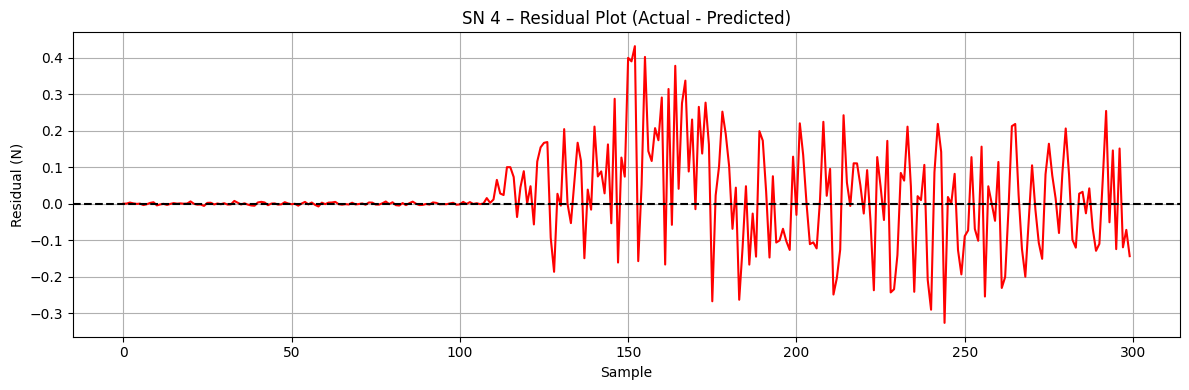

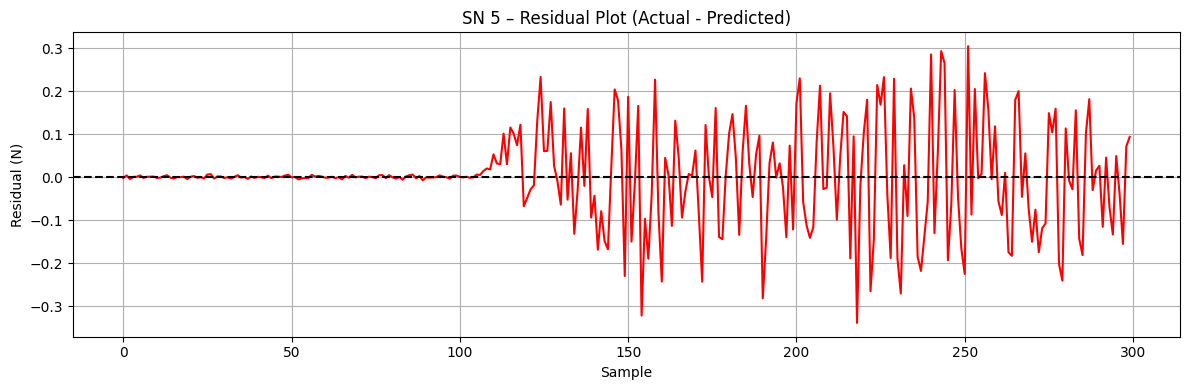

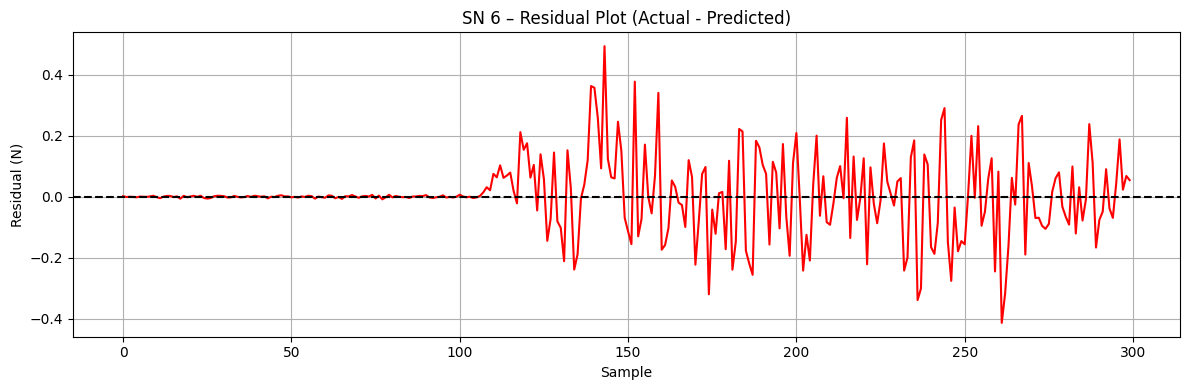

In [26]:
for sn in df_train['sn'].unique():
    df_sn = df_train[df_train['sn'] == sn]
    if df_sn.shape[0] < 100:
        print(f"⛔ SN {sn} داده کافی ندارد.")
        continue
    
    try:
        model = joblib.load(f"models/individual/xgb_model_{sn}.joblib")
        plot_residuals(sn, df_train, model, features)
    except Exception as e:
        print(f"⚠️ SN {sn}: خطا در لود مدل یا رسم نمودار: {e}")


In [15]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(sn, df, model, features, target='thrust', n_points=300):
    df_sn = df[df['sn'] == sn].dropna(subset=features + [target])
    if len(df_sn) < n_points:
        print(f"⚠️ داده کافی برای ترسیم نمودار SN{sn} وجود ندارد.")
        return
    
    X = df_sn[features].to_numpy()
    y_true = df_sn[target].to_numpy()
    
    y_pred = model.predict(X)

    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:n_points], label='Actual', color='blue')
    plt.plot(y_pred[:n_points], label='Predicted', color='orange')
    plt.title(f"SN{sn} – Actual vs Predicted Thrust")
    plt.xlabel("Sample")
    plt.ylabel("Thrust (N)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


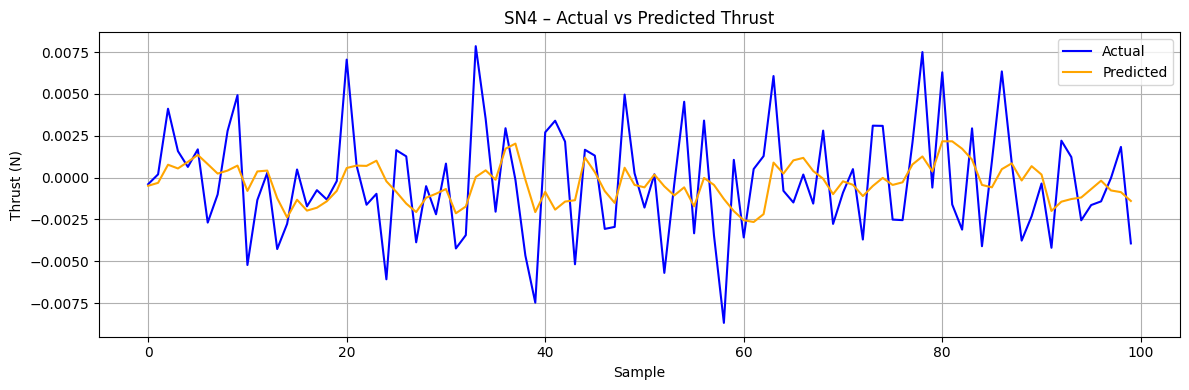

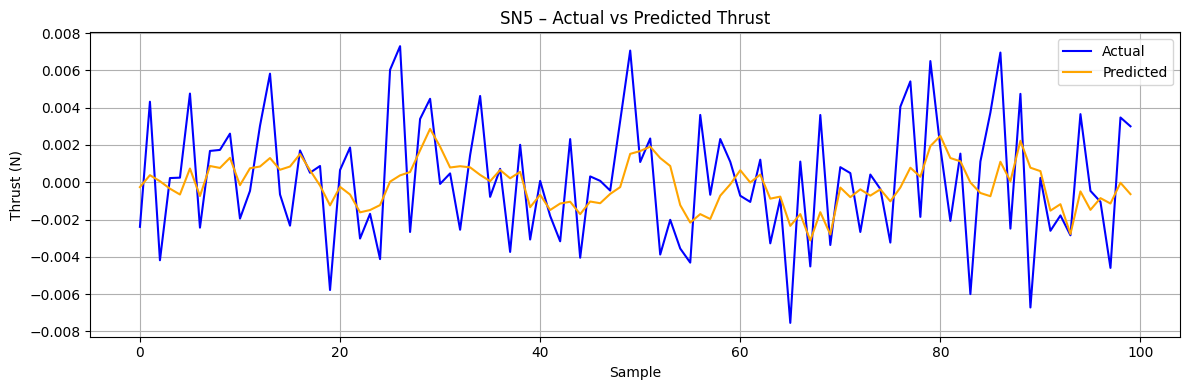

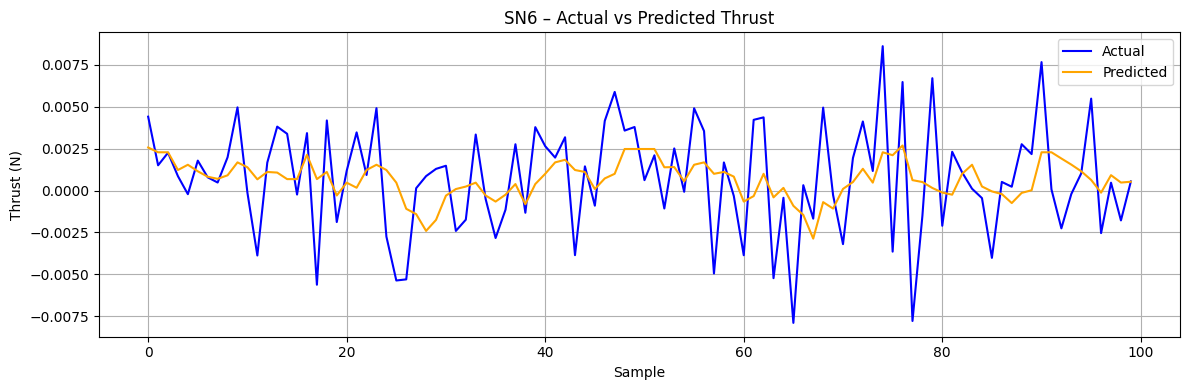

In [21]:
for sn in df_train['sn'].unique():
    df_sn = df_train[df_train['sn'] == sn]
    if df_sn.shape[0] < 100:
        print(f"⛔ SN {sn} داده کافی ندارد.")
        continue
    
    try:
        model = joblib.load(f"models/individual/xgb_model_{sn}.joblib")
        plot_actual_vs_predicted(sn, df_train, model, features, n_points=100)
    except Exception as e:
        print(f"⚠️ SN {sn}: خطا در لود مدل یا رسم نمودار: {e}")


## 📦 کد آموزش مدل مجزا برای هر SN: 7,8,9

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib


metadata_path = 'C:/Users/kingGester/Desktop/data/raw/metadata.csv'
meta = pd.read_csv(metadata_path)

def get_full_path(row):
    folder = 'train' if row['sn'] <= 12 else 'test'
    return f"C:/Users/kingGester/Desktop/data/raw/{folder}/{row['filename']}"

meta['full_path'] = meta.apply(get_full_path, axis=1)

train_data = meta[meta['sn'] .isin([7,8,9])]

def process_test_file(file_path, target_column='thrust'):
    if not os.path.exists(file_path):
        print(f"🚨 فایل {file_path} پیدا نشد.")
        return None
    try:
        df = pd.read_csv(file_path)
        if target_column not in df.columns:
            print(f"❌ ستون {target_column} در فایل {file_path} وجود ندارد.")
            return None

        df = df[['ton', target_column]].copy()
        df.dropna(inplace=True)

        on_duration = []
        count = 0
        for ton in df['ton']:
            count = count + 1 if ton == 1 else 0
            on_duration.append(count)
        df['on_duration'] = on_duration

       
        df['lag_thrust_1'] = df[target_column].shift(1)
        df.dropna(inplace=True)

        df['source_file'] = file_path
        return df

    except Exception as e:
        print(f"🚨 خطا در فایل {file_path}: {e}")
        return None


all_train_frames = []
for idx, row in train_data.iterrows():
    file_path = row['full_path']
    sn_value = row['sn']

    df = process_test_file(file_path)
    if df is not None:
        df['sn'] = sn_value
        all_train_frames.append(df)


df_train = pd.concat(all_train_frames, ignore_index=True)


df_train['rolling_avg_thrust'] = df_train.groupby('sn')['thrust'].rolling(window=5).mean().reset_index(drop=True)
df_train['cumulative_on_time'] = df_train.groupby('sn')['on_duration'].cumsum()


features = ['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time']
target = 'thrust'


os.makedirs("models/individual", exist_ok=True)

serial_numbers = df_train['sn'].unique()
results = []


for sn in serial_numbers:
    print(f"\n🔧 Training model for SN: {sn}")

    df_sn = df_train[df_train['sn'] == sn].dropna(subset=features + [target])
    
    if len(df_sn) < 100:
        print(f"⚠️ داده کافی برای {sn} وجود ندارد.")
        continue

    X = df_sn[features].to_numpy()
    y = df_sn[target].to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        'SN': sn,
        'MAE': mae,
        'R2': r2
    })

    joblib.dump(model, f"models/individual/xgb_model_{sn}.joblib")
    print(f"✅ SN {sn} | MAE: {mae:.4f} | R²: {r2:.4f}")


results_df = pd.DataFrame(results)
display(results_df.sort_values(by='R2', ascending=False).reset_index(drop=True))



🔧 Training model for SN: 7
✅ SN 7 | MAE: 0.0237 | R²: 0.9702

🔧 Training model for SN: 8
✅ SN 8 | MAE: 0.0229 | R²: 0.9786

🔧 Training model for SN: 9
✅ SN 9 | MAE: 0.0218 | R²: 0.9815


,SN,MAE,R2
0,9,0.021843,0.981472
1,8,0.022938,0.978589
2,7,0.023733,0.970213


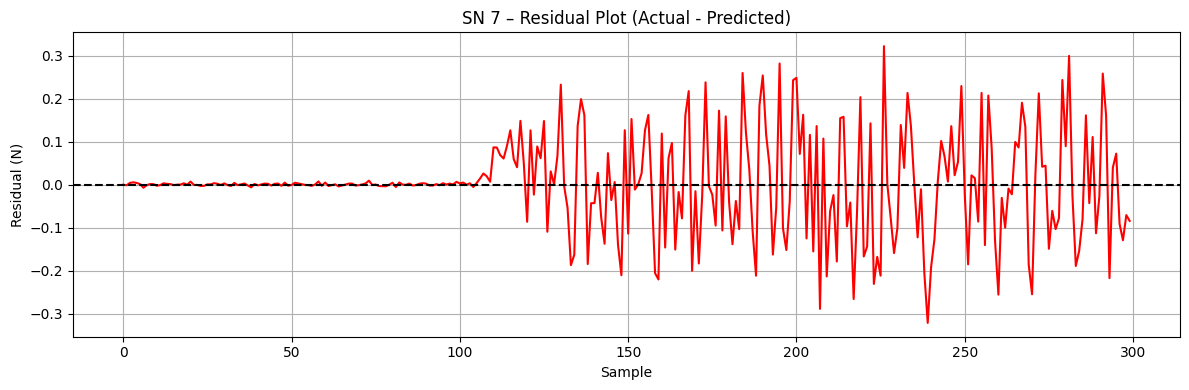

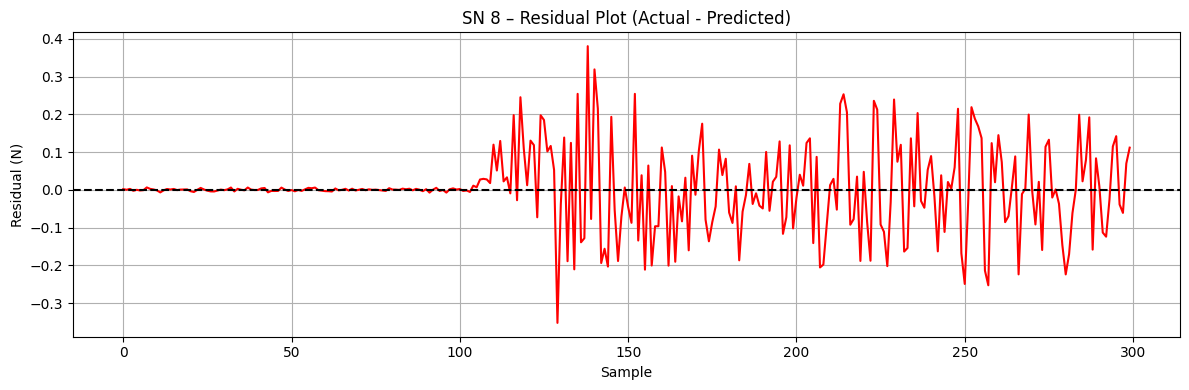

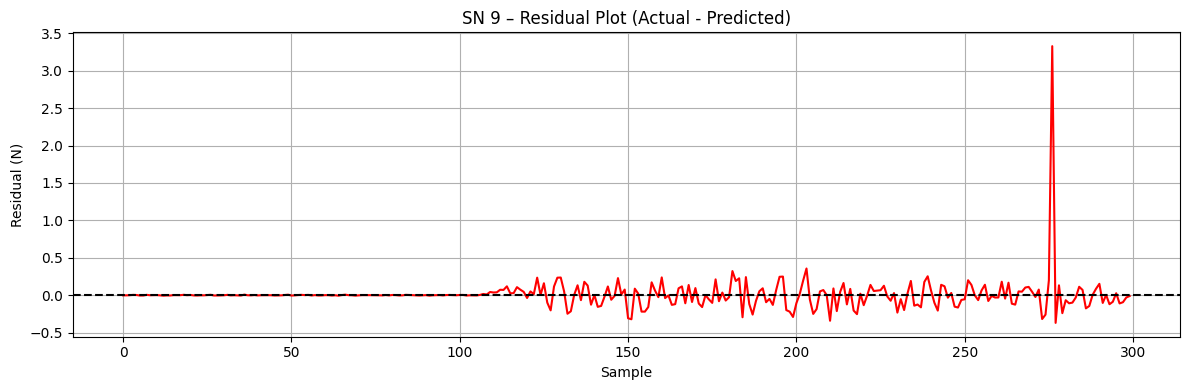

In [29]:
for sn in df_train['sn'].unique():
    df_sn = df_train[df_train['sn'] == sn]
    if df_sn.shape[0] < 100:
        print(f"⛔ SN {sn} داده کافی ندارد.")
        continue
    
    try:
        model = joblib.load(f"models/individual/xgb_model_{sn}.joblib")
        plot_residuals(sn, df_train, model, features)
    except Exception as e:
        print(f"⚠️ SN {sn}: خطا در لود مدل یا رسم نمودار: {e}")


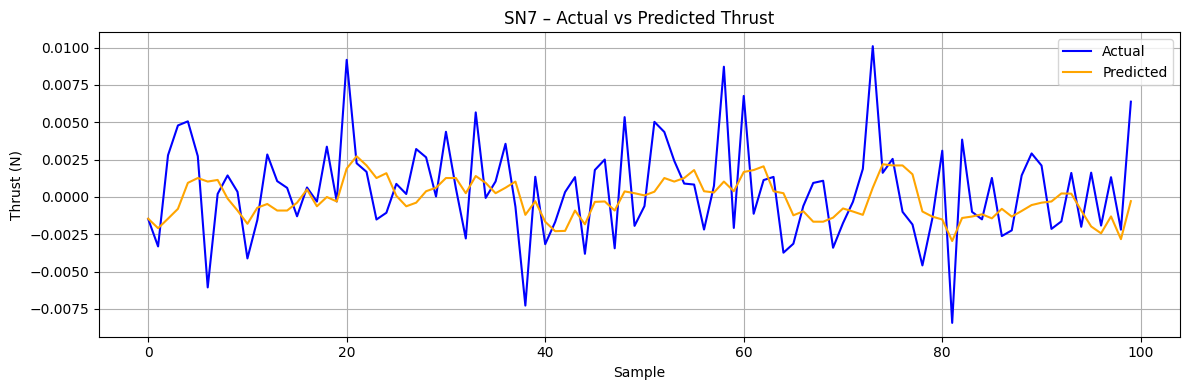

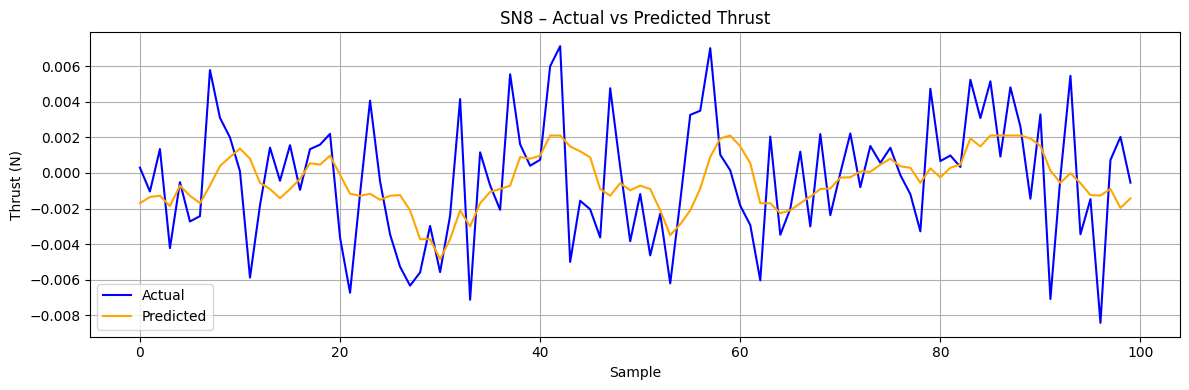

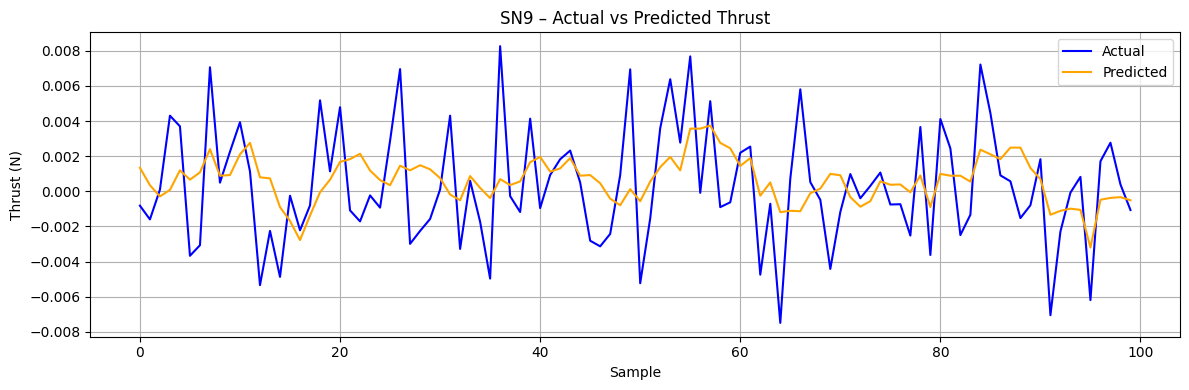

In [30]:
for sn in df_train['sn'].unique():
    df_sn = df_train[df_train['sn'] == sn]
    if df_sn.shape[0] < 100:
        print(f"⛔ SN {sn} داده کافی ندارد.")
        continue
    
    try:
        model = joblib.load(f"models/individual/xgb_model_{sn}.joblib")
        plot_actual_vs_predicted(sn, df_train, model, features, n_points=100)
    except Exception as e:
        print(f"⚠️ SN {sn}: خطا در لود مدل یا رسم نمودار: {e}")

##  📦 کد آموزش مدل مجزا برای هر SN:  10,11,12

In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# مسیر متادیتا
metadata_path = 'C:/Users/kingGester/Desktop/data/raw/metadata.csv'
meta = pd.read_csv(metadata_path)


def get_full_path(row):
    folder = 'train' if row['sn'] <= 12 else 'test'
    return f"C:/Users/kingGester/Desktop/data/raw/{folder}/{row['filename']}"

meta['full_path'] = meta.apply(get_full_path, axis=1)


train_data = meta[meta['sn'] .isin([10,11,12])]

# تابع پردازش هر فایل CSV
def process_test_file(file_path, target_column='thrust'):
    if not os.path.exists(file_path):
        print(f"🚨 فایل {file_path} پیدا نشد.")
        return None
    try:
        df = pd.read_csv(file_path)
        if target_column not in df.columns:
            print(f"❌ ستون {target_column} در فایل {file_path} وجود ندارد.")
            return None

        df = df[['ton', target_column]].copy()
        df.dropna(inplace=True)

       
        on_duration = []
        count = 0
        for ton in df['ton']:
            count = count + 1 if ton == 1 else 0
            on_duration.append(count)
        df['on_duration'] = on_duration

        
        df['lag_thrust_1'] = df[target_column].shift(1)
        df.dropna(inplace=True)

        df['source_file'] = file_path
        return df

    except Exception as e:
        print(f"🚨 خطا در فایل {file_path}: {e}")
        return None


all_train_frames = []
for idx, row in train_data.iterrows():
    file_path = row['full_path']
    sn_value = row['sn']

    df = process_test_file(file_path)
    if df is not None:
        df['sn'] = sn_value
        all_train_frames.append(df)

df_train = pd.concat(all_train_frames, ignore_index=True)


df_train['rolling_avg_thrust'] = df_train.groupby('sn')['thrust'].rolling(window=5).mean().reset_index(drop=True)
df_train['cumulative_on_time'] = df_train.groupby('sn')['on_duration'].cumsum()


features = ['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time']
target = 'thrust'


os.makedirs("models/individual", exist_ok=True)

serial_numbers = df_train['sn'].unique()
results = []


for sn in serial_numbers:
    print(f"\n🔧 Training model for SN: {sn}")

    df_sn = df_train[df_train['sn'] == sn].dropna(subset=features + [target])
    
    if len(df_sn) < 100:
        print(f"⚠️ داده کافی برای {sn} وجود ندارد.")
        continue

    X = df_sn[features].to_numpy()
    y = df_sn[target].to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        'SN': sn,
        'MAE': mae,
        'R2': r2
    })

    joblib.dump(model, f"models/individual/xgb_model_{sn}.joblib")
    print(f"✅ SN {sn} | MAE: {mae:.4f} | R²: {r2:.4f}")


results_df = pd.DataFrame(results)
display(results_df.sort_values(by='R2', ascending=False).reset_index(drop=True))



🔧 Training model for SN: 10
✅ SN 10 | MAE: 0.0345 | R²: 0.9794

🔧 Training model for SN: 11
✅ SN 11 | MAE: 0.0230 | R²: 0.9812

🔧 Training model for SN: 12
✅ SN 12 | MAE: 0.0172 | R²: 0.9838


,SN,MAE,R2
0,12,0.017229,0.983764
1,11,0.023003,0.981229
2,10,0.034547,0.979449


## 📊 جدول نتایج مقایسه‌ای SNها:

In [32]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)


,SN,MAE,R2
0,12,0.017229,0.983764
1,11,0.023003,0.981229
2,10,0.034547,0.979449


## ✨ نتیجه‌گیری:
مدل‌های مجزا برای هر SN ساخته شدند و در بسیاری از موارد عملکرد بهتری نسبت به مدل کلی دارند.

در گام بعدی، مدل‌های پیش‌بینی وضعیت VL (یعنی خطر VL2 یا VL3) طراحی خواهند شد تا از آسیب احتمالی پیشران جلوگیری شود.

نوت‌بوک بعدی:
📘 05_vl_detection_and_prevention.ipynb
